In [1]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms as T
from cifar10_models.resnet import resnet18
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import tqdm

In [2]:
# pretest resnet18 model.
# resnet = resnet18(pretrained=True)
# resnet.out_features = resnet.fc.out_features
# loss, accuracy = test(resnet, test_loader_normal, crit)
# print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")

# util functions.

In [3]:
def seedall(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

In [4]:
def loaders(bs):
    # init train and test loaders.
    means = (0.4914, 0.4822, 0.4465)
    stds = (0.2471, 0.2435, 0.2616)
    transform = T.Compose([T.ToTensor(), T.Normalize(means, stds)])
    train_data_normal = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data_normal = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
    train_loader_normal = DataLoader(train_data_normal, batch_size=bs, shuffle=True)
    test_loader_normal = DataLoader(test_data_normal, batch_size=bs, shuffle=False)
    return train_loader_normal, test_loader_normal

In [28]:
def eigengram(W):
    # compute eigenvals.
    eigenvalues, eigenvectors = np.linalg.eig(W.T @ W)
    # Might get some complex dust due to precision.
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    return eigenvalues

In [43]:
def eigenspectra(ax, eigenvals, title):
    ax.hist(eigenvals, bins=50, color='steelblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('eigenvalue')
    ax.set_ylabel('frequency')
    ax.grid(alpha=0.3)
    ax.set_yscale('log')

In [23]:
def showcase(W):
    fig, ax = plt.subplots(figsize=(6, 6))
    im1 = ax.imshow(abs(W).T, cmap='inferno', interpolation='nearest')
    ax.set_xticks([]); ax.set_yticks([]);

# define the proper model.

In [8]:
def to_one_hot(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes).float()

class MLP(torch.nn.Module):
    def __init__(self, inp_size, out_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(inp_size, inp_size),
            torch.nn.Linear(inp_size, inp_size),
            torch.nn.Linear(inp_size, out_size), # no logsoftmax
        )

    def forward(self, x):
        return self.layers(x)

class PretrainedResnet(torch.nn.Module):
    def __init__(self):
        super(PretrainedResnet, self).__init__()
        self.resnet = self.setup_resnet()
        self.head = self.setup_head()
        self.model = torch.nn.Sequential(self.resnet, self.head)
        self.set_init()

    def setup_resnet(self):
        resnet = resnet18(pretrained=True)
        self.in_features = resnet.fc.in_features
        self.out_features = resnet.fc.out_features
        resnet.fc = torch.nn.Identity() # peel fc layer.
        # freeze params.
        for param in resnet.parameters():
            param.requires_grad = False
        resnet.eval();
        return resnet
    
    def setup_head(self):
        return MLP(self.in_features, self.out_features)

    def set_init(self):
        self.W1_init = self.head.layers[0].weight.detach().clone().numpy()
        self.u_init, self.s_init, self.vh_init = np.linalg.svd(self.W1_init)
        self.W1_init_svd = self.W1_init @ self.vh_init.T

    def set_post(self):
        self.W1_post = self.head.layers[0].weight.detach().clone().numpy()
        self.u_post, self.s_post, self.vh_post = np.linalg.svd(self.W1_post)
        self.W1_post_svd = self.W1_post @ self.vh_post.T

    def forward(self, x):
        return self.model(x)
    
    @staticmethod
    def norm(model):
        norm = 0
        for param in model.parameters():
            norm += param.data.norm(2) ** 2
        return norm

# training loop utils.

In [9]:
def train(model, train_loader, crit, opt, n_iters, clip_value=-1, seed_traj=0):
    # Set the trajectory seed.
    seedall(seed_traj)
    np.random.seed(seed_traj)
    torch.manual_seed(seed_traj)
    random.seed(seed_traj)

    model.train()
    pbar = tqdm.tqdm(range(n_iters))
    iters_idx, epoch_idx = 0, 0
    losses = []

    while iters_idx < n_iters:
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if iters_idx >= n_iters: break

            # forward pass.
            outputs = model(inputs)
            targets = to_one_hot(targets, model.out_features)
            
            # backward pass.
            opt.zero_grad()
            loss = crit(outputs, targets)
            loss.backward()
            if clip_value > 0:
                torch.clip_grad_norm_(model.parameters(), clip_value)
            opt.step()
            losses.append(loss.item())

            # move progress bar.
            pbar.set_description(f"epoch {epoch_idx+1} iter {iters_idx+1}/{n_iters} | train loss {loss.item():.3f} | norm {model.norm(model.head):.3f}")
            pbar.update(1)
            iters_idx += 1

        epoch_idx += 1

    pbar.close()
    model.eval()
    return losses

In [10]:
def test(model, test_loader, crit):
    model.eval()
    correct = 0
    total_loss = 0.
    
    iters_idx = 0
    n_iters = len(test_loader)
    pbar = tqdm.tqdm(range(n_iters))
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            loss = crit(outputs, to_one_hot(targets, model.out_features))
            total_loss += loss.item()
            # move progress bar.
            pbar.set_description(f"iter {iters_idx+1}/{n_iters}")
            pbar.update(1)
            iters_idx += 1

    pbar.close()
    accuracy = 100. * (correct / len(test_loader.dataset))
    loss = total_loss / len(test_loader)
    return loss, accuracy

In [11]:
crit = torch.nn.MSELoss()
seed_init = 0

# create the ground truth model.

In [12]:
# set init seed.
seedall(seed_init)
# init model and optim.
model_gold = PretrainedResnet()
train_loader, test_loader = loaders(bs=64)
opt_gold = torch.optim.SGD(model_gold.parameters(), lr=0.1, weight_decay=0.008)
# train and test the model.
train(model_gold, train_loader, crit, opt_gold, n_iters=5000)
loss, accuracy = test(model_gold, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")
model_gold.set_post()

Files already downloaded and verified
Files already downloaded and verified


epoch 7 iter 5000/5000 | train loss 0.012 | norm 7.939: 100%|██████████| 5000/5000 [30:48<00:00,  2.71it/s]  
iter 157/157: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


test loss 0.014 | test accuracy 91.56


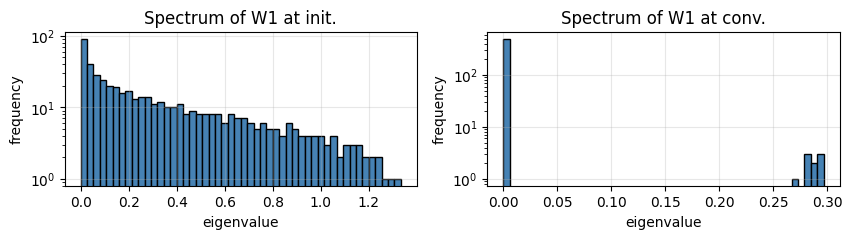

In [44]:
# plot the eigenspectra.
plt.figure(figsize=(10, 2))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
eigenspectra(ax1, eigengram(model_gold.W1_init), 'Spectrum of W1 at init.')
eigenspectra(ax2, eigengram(model_gold.W1_post), 'Spectrum of W1 at conv.')
plt.show();

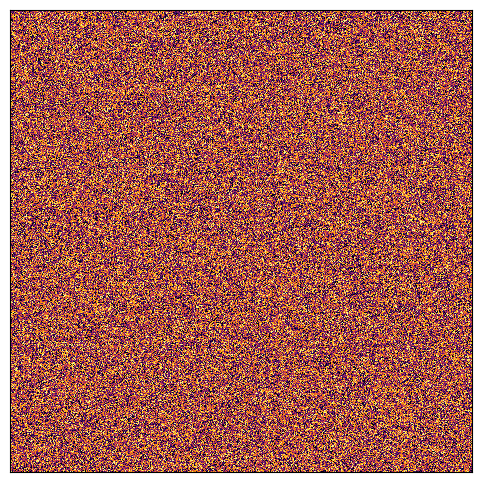

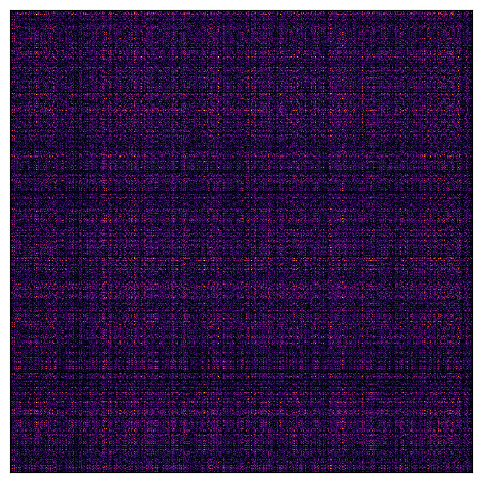

In [45]:
showcase(model_gold.W1_init);
showcase(model_gold.W1_post);

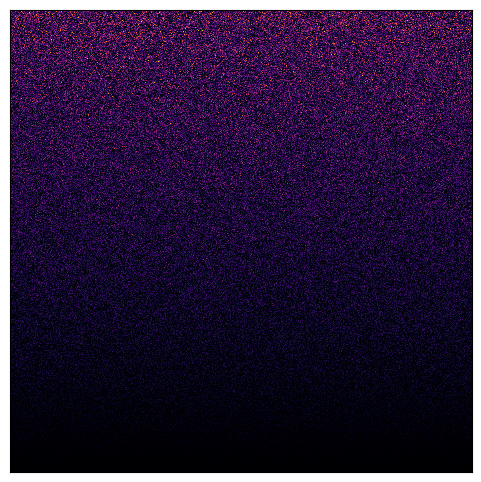

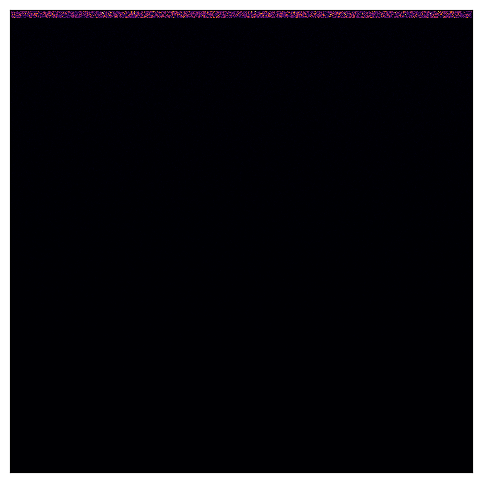

In [46]:
showcase(model_gold.W1_init_svd);
showcase(model_gold.W1_post_svd);

# update the training function based on ground truth.

In [49]:
def train(model, train_loader, crit, opt, n_iters, clip_value=-1, seed_traj=0):
    # Set the trajectory seed.
    np.random.seed(seed_traj)
    torch.manual_seed(seed_traj)
    random.seed(seed_traj)

    model.train()
    pbar = tqdm.tqdm(range(n_iters))
    iters_idx, epoch_idx = 0, 0
    irelnorms, losses = [], []

    while iters_idx < n_iters:
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if iters_idx >= n_iters: break

            # forward pass.
            z = model.resnet(inputs) # get the features from the CNN.
            zproj = z@model_gold.vh_post.T # project the features.
            outputs = model.head(zproj) # get the predictions.
            targets = to_one_hot(targets, model.out_features)
            
            # backward pass.
            opt.zero_grad()
            loss = crit(outputs, targets)
            loss.backward()
            if clip_value > 0:
                torch.clip_grad_norm_(model.parameters(), clip_value)
            opt.step()
            losses.append(loss.item())

            W1_i = model.head.layers[0].weight.detach().clone().numpy()
            sz_cols = W1_i.shape[0]
            irelnorms.append([np.linalg.norm(W1_i[:, j], ord=1) for j in range(sz_cols)])

            # move progress bar.
            pbar.set_description(f"epoch {epoch_idx+1} iter {iters_idx+1}/{n_iters} | train loss {loss.item():.3f} | norm {model.norm(model.head):.3f}")
            pbar.update(1)
            iters_idx += 1

        epoch_idx += 1

    pbar.close()
    model.eval()
    return irelnorms, losses

# train with adam then sgd.

In [50]:
# set init seed.
seedall(seed_init)
# init model and optim.
mod = PretrainedResnet()
train_loader, test_loader = loaders(bs=64)
opt_p01 = torch.optim.Adam(mod.parameters())
# train and test the model.
norms, losses = train(mod, train_loader, crit, opt_p01, n_iters=250)
loss, accuracy = test(mod, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")
mod.set_post()

Files already downloaded and verified
Files already downloaded and verified


epoch 1 iter 250/250 | train loss 0.011 | norm 379.408: 100%|██████████| 250/250 [02:14<00:00,  1.86it/s]
iter 157/157: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]


test loss 0.126 | test accuracy 6.04


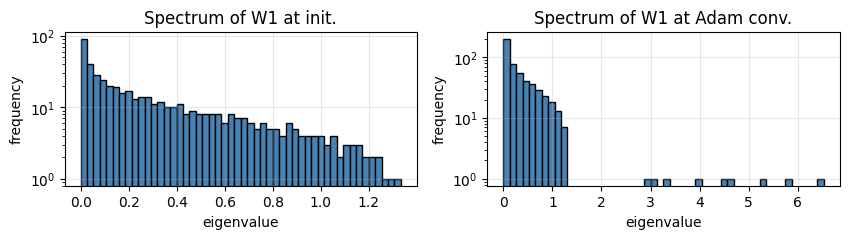

In [52]:
# plot the eigenspectra.
plt.figure(figsize=(10, 2))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
eigenspectra(ax1, eigengram(mod.W1_init), 'Spectrum of W1 at init.')
eigenspectra(ax2, eigengram(mod.W1_post), 'Spectrum of W1 at Adam conv.')
plt.show();

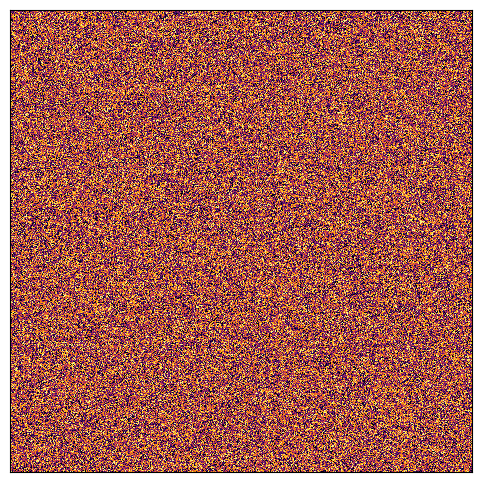

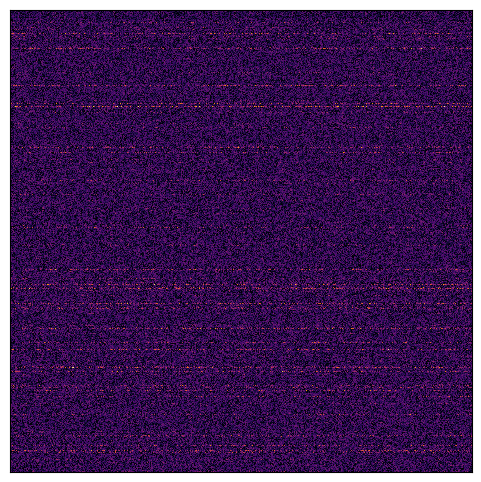

In [53]:
showcase(mod.W1_init);
showcase(mod.W1_post);

In [60]:
# resume training with sgd.
opt_p02 = torch.optim.SGD(mod.parameters(), lr=0.01)
# train and test the model.
norms, losses = train(mod, train_loader, crit, opt_p02, n_iters=500)
loss, accuracy = test(mod, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")

epoch 1 iter 500/500 | train loss 0.005 | norm 380.462: 100%|██████████| 500/500 [04:31<00:00,  1.84it/s]
iter 157/157: 100%|██████████| 157/157 [00:56<00:00,  2.80it/s]

test loss 0.139 | test accuracy 1.03


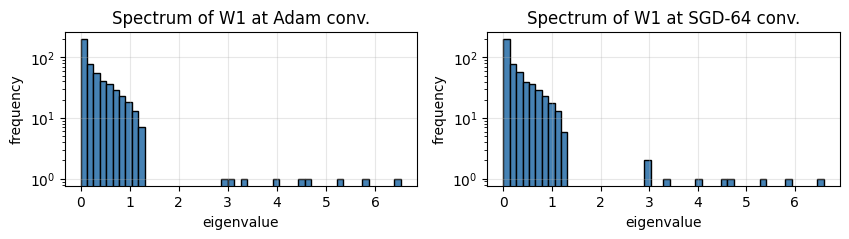

In [61]:
Wphase02 = mod.head.layers[0].weight.detach().clone().numpy()
# plot the eigenspectra.
plt.figure(figsize=(10, 2))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
eigenspectra(ax1, eigengram(mod.W1_post), 'Spectrum of W1 at Adam conv.')
eigenspectra(ax2, eigengram(Wphase02), 'Spectrum of W1 at SGD-64 conv.')
plt.show();

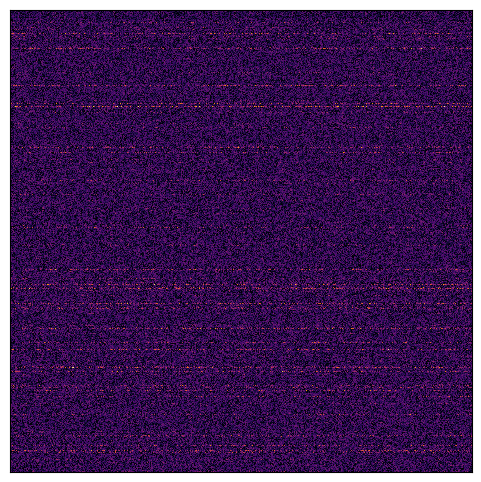

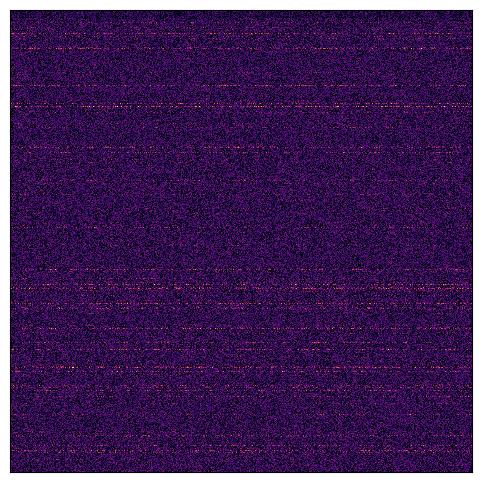

In [62]:
showcase(mod.W1_post);
showcase(Wphase02);

In [ ]:
assert False

# for the linear head model. without wd.

In [ ]:
# set init seed.
seedall(seed_init)
# init model and optim.
model_512 = PretrainedResnet()
# give a hint to the init
model_512.W1_init = model_512.W1_init @ model_512.vh_init.T
model_512.head.layers[0].weight.data = torch.tensor(model_512.W1_init, dtype=torch.float32)
train_loader, test_loader = loaders(bs=512)
opt_512 = torch.optim.SGD(model_512.parameters(), lr=0.1)
# train and test the model.
norms_512, losses_512 = train(model_512, train_loader, crit, opt_512, n_iters=5000)
loss, accuracy = test(model_512, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")
model_512.set_post()

In [ ]:
# set init seed.
seedall(seed_init)
# init model and optim.
model_64 = PretrainedResnet()
model_64.W1_init = model_64.W1_init @ model_64.vh_init.T
model_64.head.layers[0].weight.data = torch.tensor(model_64.W1_init, dtype=torch.float32)
train_loader, test_loader = loaders(bs=64)
opt_64 = torch.optim.SGD(model_64.parameters(), lr=0.1)
# train and test the model.
norms_64, losses_64 = train(model_64, train_loader, crit, opt_64, n_iters=5000)
loss, accuracy = test(model_64, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")
model_64.set_post()

In [ ]:
# set init seed.
seedall(seed_init)
# init model and optim.
model_32 = PretrainedResnet()
model_32.W1_init = model_32.W1_init @ model_32.vh_init.T
model_32.head.layers[0].weight.data = torch.tensor(model_32.W1_init, dtype=torch.float32)
train_loader, test_loader = loaders(bs=32)
opt_32 = torch.optim.SGD(model_32.parameters(), lr=0.1)
# train and test the model.
norms_32, losses_32 = train(model_32, train_loader, crit, opt_32, n_iters=5000)
loss, accuracy = test(model_32, test_loader, crit)
print(f"test loss {loss:.3f} | test accuracy {accuracy:.2f}")
model_32.set_post()

In [ ]:
W1_512 = model_512.head.layers[0].weight.detach().clone().numpy()
W1_64 = model_64.head.layers[0].weight.detach().clone().numpy()
W1_32 = model_32.head.layers[0].weight.detach().clone().numpy()

In [ ]:
col = 350
ts = 5000

plt.plot([norms_512[i][col] for i in range(ts)], label='sgd-512')
plt.plot([norms_64[i][col] for i in range(ts)], label='sgd-64')
plt.plot([norms_32[i][col] for i in range(ts)], label='sgd-04')
plt.title('CIFAR10 Resnet+LinearHead irrelevants norms')
plt.grid(True, linestyle='-', linewidth=0.2, color='gray')
plt.legend()
plt.yscale('log')
plt.show();

# plot the weight layers

In [ ]:
showcase(model_512.W1_post);
showcase(model_64.W1_post);
showcase(model_32.W1_post);